In [1]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import pickle

# Importando variáveis de treino e teste desenvolvidos na etapa de preparação dos dados

In [2]:
def open_train_test():
  with open('train_test.pkl','rb') as f:
    return pickle.load(f)

In [3]:
X_train, X_test, y_train, y_test = open_train_test()

# GridSearchCV
O GridSearchCV é um módulo do Scikit Learn e é amplamente usado para automatizar grande parte do processo de tuning. O objetivo primário do GridSearchCV é a criação de combinações de parâmetros para posteriormente avaliá-las.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

Vamos visualizar os resultados dos testes utitlizando 4 métricas diferentes  
- **Precision**: é usada para medir o desempenho do modelo ao medir a contageem de positivos verdadeiros da maneira correta de todas as previsões positivas feitas.
- **Recall**: é usada para medir o desempenho do modelo ao medir a contagem de positivos verdadeiros de maneira correta de todos os valores posititvos reais.
- **Precision**: é usada para medir o desempenho do modelo ao medir a razão da soma de positivos verdadeiros e verdadeiros negativos de todas as previsões
- **F1-score**: é a média harmônica de precision e recall e é usada como uma métrica nos cenários em que a escolha de precisão ou pontuação de recall pode resultar em comprometimento em termos de modelo dando altos falsos positivos e falsos negativos, respectivamente.

In [5]:
metrics = {'accuracy' :make_scorer(accuracy_score),
           'recall'   :make_scorer(recall_score),
           'precision':make_scorer(precision_score),
           'f1'       :make_scorer(fbeta_score, beta = 1)}

## Cross Validation
O Cross validation cria várias combinações diferentes para treino e teste, o que torna o resultado das métricas mais preciso e condizente com o desempenho real do algoritmo.  

Para definir o número de CV no nosso algoritmo, vamos utilizar o StratifiedShuffleSplit, que fornece índices de treinamento/teste para dividir dados em conjuntos de treinamento/teste.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

cv_sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2)

# Decision Tree



## Teste 1
Na primeira etapa de teste do Decision Tree, vamos utilizar o conjunto dos parâmetros possíveis para esse modelo. A partir dos resultados obtidos, vamos realizar o afunilamento de parâmetros para extrair a melhor combinação possível

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

In [8]:
dt_parameters = {
       'criterion':  ['gini', 'entropy']
      ,'min_samples_split': [2,3,5,7]
      ,'max_depth': [3,5,6,7,9,11,13,15]
      ,'min_samples_leaf':  [2, 3]
}

In [15]:
def dt_count(df, count = False, **kargs):
  cri, min_sam_sp, max_dep, min_sam_le = dict(), dict(), dict(), dict()

  for param in kargs['criterion']:
    cri[param] = 0
  
  for param in kargs['min_samples_split']:
    min_sam_sp[param] = 0
  
  for param in kargs['max_depth']:
    max_dep[param] = 0
  
  for param in kargs['min_samples_leaf']:
    min_sam_le[param] = 0

  dt_params_count = {
        'criterion': cri
      , 'min_samples_split': min_sam_sp
      , 'max_depth': max_dep
      , 'min_samples_leaf': min_sam_le
  }

  if not count:
    count = df.shape[0]

  for i in range(count):
    criterion         = df['params'][i]['criterion']
    min_samples_split = df['params'][i]['min_samples_split']
    max_depth         = df['params'][i]['max_depth']
    min_samples_leaf  = df['params'][i]['min_samples_leaf']

    dt_params_count['criterion'][criterion] += 1
    dt_params_count['min_samples_split'][min_samples_split] += 1
    dt_params_count['max_depth'][max_depth] += 1
    dt_params_count['min_samples_leaf'][min_samples_leaf] += 1

  return dt_params_count

In [10]:
%%capture
test_1_dt = GridSearchCV(estimator = dt,
                      param_grid = dt_parameters,
                      cv = cv_sss,
                      scoring = metrics,
                      refit=False)

test_1_dt.fit(X_train, y_train)

In [11]:
df_dt_1 = pd.DataFrame(test_1_dt.cv_results_)[['params', 'rank_test_f1', 'rank_test_accuracy', 'rank_test_recall', 'rank_test_precision','mean_test_accuracy', 'mean_test_recall','mean_test_precision','mean_test_f1']]
df_dt_1.sort_values(by=['rank_test_f1', 'rank_test_accuracy', 'rank_test_recall', 'rank_test_precision'], inplace=True)
df_dt_1.reset_index(drop=True, inplace=True)

In [12]:
print(f"Verificando os 5 melhores resultados das {df_dt_1.shape[0]} combinações diferentes ordenados por: rank_test_f1, rank_test_accuracy, rank_test_recall e rank_test_precision")

Verificando os 5 melhores resultados das 128 combinações diferentes ordenados por: rank_test_f1, rank_test_accuracy, rank_test_recall e rank_test_precision


In [13]:
df_dt_1.head()

,params,rank_test_f1,rank_test_accuracy,rank_test_recall,rank_test_precision,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
0,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",1,3,33,21,0.826372,0.809330,0.838176,0.823054
1,"{'criterion': 'entropy', 'max_depth': 15, 'min...",2,1,35,13,0.826730,0.805024,0.841286,0.822465
2,"{'criterion': 'entropy', 'max_depth': 15, 'min...",3,2,37,14,0.826611,0.804785,0.841157,0.822268
3,"{'criterion': 'entropy', 'max_depth': 15, 'min...",4,5,34,22,0.824821,0.805024,0.838026,0.820865
4,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",5,6,35,25,0.824344,0.805024,0.837825,0.820579


### Realizando a contagem dos parâmetros que foram utitlizados nas 10 melhores classificações

In [16]:
dt_count(df = df_dt_1, count = 10
          , criterion = dt_parameters['criterion']
          , min_samples_split = dt_parameters['min_samples_split']
          , max_depth = dt_parameters['max_depth']
          , min_samples_leaf = dt_parameters['min_samples_leaf'])

{'criterion': {'entropy': 4, 'gini': 6},
 'max_depth': {3: 0, 5: 0, 6: 0, 7: 0, 9: 0, 11: 0, 13: 0, 15: 10},
 'min_samples_leaf': {2: 8, 3: 2},
 'min_samples_split': {2: 2, 3: 2, 5: 3, 7: 3}}

## Teste 2
Vamos utitlizar os parâmetros mais recorrentes nas melhores classificações e realizar uma segunda rodada de testes para determinar a melhor combinação de parâmetros

In [30]:
dt_parameters = {
       'criterion':  ['gini', 'entropy']
      ,'min_samples_split': [5,7,9]
      ,'max_depth': [15, 17, 19, 21, 23]
      ,'min_samples_leaf':  [2]
}

In [31]:
%%capture
test_2_dt = GridSearchCV(estimator = dt,
                      param_grid = dt_parameters,
                      cv = cv_sss,
                      scoring = metrics,
                      refit=False)

test_2_dt.fit(X_train, y_train)

In [32]:
df_dt_2 = pd.DataFrame(test_2_dt.cv_results_)[['params', 'rank_test_f1', 'rank_test_accuracy', 'rank_test_recall', 'rank_test_precision','mean_test_accuracy', 'mean_test_recall','mean_test_precision','mean_test_f1']]
df_dt_2.sort_values(by=['rank_test_f1', 'rank_test_accuracy', 'rank_test_recall', 'rank_test_precision'], inplace=True)
df_dt_2.reset_index(drop=True, inplace=True)

In [33]:
print(f"Verificando os 5 melhores resultados das {df_dt_2.shape[0]} combinações diferentes ordenados por: rank_test_f1, rank_test_accuracy, rank_test_recall e rank_test_precision")

Verificando os 5 melhores resultados das 30 combinações diferentes ordenados por: rank_test_f1, rank_test_accuracy, rank_test_recall e rank_test_precision


In [34]:
df_dt_2.head()

,params,rank_test_f1,rank_test_accuracy,rank_test_recall,rank_test_precision,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
0,"{'criterion': 'entropy', 'max_depth': 23, 'min...",1,1,7,3,0.844272,0.840191,0.847152,0.843239
1,"{'criterion': 'entropy', 'max_depth': 23, 'min...",2,2,11,2,0.843675,0.838278,0.847468,0.842486
2,"{'criterion': 'entropy', 'max_depth': 23, 'min...",3,4,6,14,0.841766,0.840670,0.842319,0.841215
3,"{'criterion': 'entropy', 'max_depth': 21, 'min...",4,3,12,7,0.842243,0.836842,0.845927,0.840974
4,"{'criterion': 'entropy', 'max_depth': 21, 'min...",5,5,15,8,0.841408,0.835646,0.845524,0.840091


In [35]:
dt_count(df = df_dt_2, count = 10
          , criterion = dt_parameters['criterion']
          , min_samples_split = dt_parameters['min_samples_split']
          , max_depth = dt_parameters['max_depth']
          , min_samples_leaf = dt_parameters['min_samples_leaf'])

{'criterion': {'entropy': 7, 'gini': 3},
 'max_depth': {15: 0, 17: 0, 19: 2, 21: 4, 23: 4},
 'min_samples_leaf': {2: 10},
 'min_samples_split': {5: 3, 7: 3, 9: 4}}

In [36]:
dt_best_param = df_dt_2['params'][0]

In [37]:
criterion         = dt_best_param['criterion']
min_samples_split = dt_best_param['min_samples_split']
max_depth         = dt_best_param['max_depth']
min_samples_leaf  = dt_best_param['min_samples_leaf']
dt_best_param

{'criterion': 'entropy',
 'max_depth': 23,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

# Classificação com os melhores parâmetros

In [38]:
dt = DecisionTreeClassifier(criterion = criterion, min_samples_leaf = min_samples_leaf, max_depth = max_depth, min_samples_split = min_samples_split)
dt.fit(X_train, y_train);
y_pred = dt.predict(X_test)

In [39]:
print('1: Masculino\n2: Feminino\n',classification_report(y_test, y_pred))

1: Masculino
2: Feminino
               precision    recall  f1-score   support

           1       0.85      0.83      0.84       704
           2       0.83      0.86      0.84       692

    accuracy                           0.84      1396
   macro avg       0.84      0.84      0.84      1396
weighted avg       0.84      0.84      0.84      1396



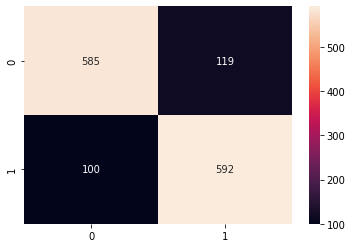

In [40]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

# Exportando modelo treinado

In [41]:
path = '/content/drive/MyDrive/Mineração de Dados/IF998 - Missões SMD/Projeto/'
with open(path+'DT_model.pkl', 'wb') as f:
    pickle.dump([dt], f) 